## Scenario Discovery and Policy Exploration


This notebook is part of Open Exploration. Scenario Discovery and Policy Exploration is done using Patient Rule Induction Method (PRIM) algorithm which is a part of the ema_workbench. PRIM is preferred over subspace partitioning methods such as CART (Classification and Regression Tree) as PRIM algorithm is more user-interactive as can be seen below and requires lesser work by the analyst to create box sets that have high interpretability. This notebook consists of two parts. First the uncertainties are explored to get the worst case scenarios and second, the policy levers available are compared based on their out comes. 

Lastly, a dimensional stacking / feature scoring is done to give insights into sensitivity. 

In [1]:
# import the libaries
from ema_workbench import load_results
from ema_workbench.analysis import parcoords
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from ema_workbench.analysis import prim
import numpy as np
from ema_workbench.util import ema_logging

In [2]:
# load the basecase results

df_base = pd.read_csv("results/base_case_without_NaN.csv")
df_base.drop(columns=["Unnamed: 0"],inplace=True)
#df_base.head(2)

In [3]:
df_base.columns
#this has all objectives (3) per dike ring x (3) timestep + 2 total 

Index(['A.1_Expected Annual Damage 0', 'A.1_Dike Investment Costs 0',
       'A.1_Expected Number of Deaths 0', 'A.2_Expected Annual Damage 0',
       'A.2_Dike Investment Costs 0', 'A.2_Expected Number of Deaths 0',
       'A.3_Expected Annual Damage 0', 'A.3_Dike Investment Costs 0',
       'A.3_Expected Number of Deaths 0', 'A.4_Expected Annual Damage 0',
       ...
       'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1',
       'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1',
       'A.5_DikeIncrease 2', 'scenario', 'policy', 'model'],
      dtype='object', length=104)

In [4]:
#split base case in outcomes and experiments
outcomes=df_base.iloc[:,:51]
experiments=df_base.iloc[:,51:]

Aggregate over time to remove timestep. Excluding RfR costs and Expected Evactuation Costs

In [5]:
# Aggregate over time and location to obtain the desired shape of the outcomes
def aggregate_df(df):
    df_aggregate = pd.DataFrame()
    dikerings = ['A.1', 'A.2', 'A.3', 'A.4', 'A.5']
    timestep = ['0', '1', '2']
    metrics = ['Expected Annual Damage', 'Dike Investment Costs', 'Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs']
    
    for metric in metrics:
        if metric == "RfR Total Costs" or metric == "Expected Evacuation Costs":

            columns = [metric + ' ' + time for time in timestep]

            df_aggregate[metric] = df[columns].sum(axis=1)
        else:
            for dikering in dikerings:
                columns = [dikering + '_' + metric + ' ' + time for time in timestep]

                df_aggregate[dikering + '_' + metric] = df[columns].sum(axis=1)
            
            columns_locations = [dikering + '_' + metric for dikering in dikerings]
            df_aggregate['Total ' + metric] = df_aggregate[columns_locations].sum(axis=1)
    
 
    return df_aggregate

In [6]:
#Choosing our objectives as the outcomes
#Dike investment Costs of Dike Ring 1 should be zero since no policies are yet implemented in the basecase
df_aggregate=aggregate_df(outcomes)
outcomes_objectives = ["A.1_Expected Annual Damage","A.1_Dike Investment Costs",\
                        "A.1_Expected Number of Deaths","Total Expected Number of Deaths",\
                        "Total Expected Annual Damage"]
df_aggregate = df_aggregate[outcomes_objectives]
df_aggregate.head(2)

,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths,Total Expected Number of Deaths,Total Expected Annual Damage
0,1.513913e+07,0,0.013092,0.199524,1.859643e+08
1,2.148814e+09,0,1.834596,4.069313,3.423863e+09


In [7]:
df_aggregate.columns #contains only outcomes of interest

Index(['A.1_Expected Annual Damage', 'A.1_Dike Investment Costs',
       'A.1_Expected Number of Deaths', 'Total Expected Number of Deaths',
       'Total Expected Annual Damage'],
      dtype='object')

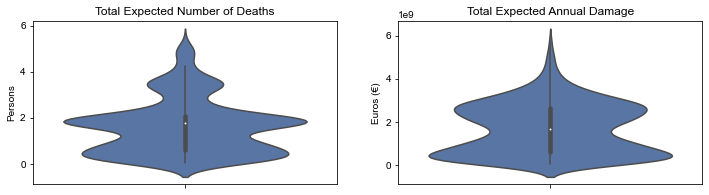

In [8]:
# #First we are going to look at the totals

# plotting the number of deaths and the damage costs (aggregated over time and location)
f, axes = plt.subplots(1, 2, figsize=(12,3))
sns.set(style="whitegrid", font_scale=1)
plt.rcParams["axes.labelsize"] = 15

sns.violinplot(data=df_aggregate["Total Expected Number of Deaths"], ax=axes[0])
sns.violinplot(data=df_aggregate["Total Expected Annual Damage"], ax=axes[1])

#layout of the plots
axes[0].set_title("Total Expected Number of Deaths")
axes[0].set_ylabel('Persons')
axes[0].set(xticklabels = [])

axes[1].set_title("Total Expected Annual Damage")
axes[1].set_ylabel('Euros (€)')
axes[1].set(xticklabels = [])

plt.show()

The scenario discovery is done based on two outcomes. Total Expected Number of Deaths and Total Expected Annual Damage.
As seen previously in the Base case, we see that a number of scenarios score low Expected number of Deaths, but there are also a lot of scenarios which score high. 2 deaths was set as the upper limit for the Expected number of deaths.

Looking at total annual damage, we see that there are also some low scoring scenarios but also a lot of high scoring ones. We see that at 2.5e+09 the tip of the violin starts. Let's check which percentages of scenarios score this high.

In [9]:
# Scenarios score high on both objectives is checked for both the deaths and the expected annual damage

total= df_aggregate["Total Expected Number of Deaths"].count()
print("Total number of scenarios is", total, "scenarios.")
count_total_death = df_aggregate["Total Expected Number of Deaths"][df_aggregate["Total Expected Number of Deaths"]>2].count()
print(count_total_death, "is", count_total_death/total*100, "% of", total, "scenarios score higher than 2 people")
count_total_damage = df_aggregate["Total Expected Annual Damage"][df_aggregate["Total Expected Annual Damage"]>2500000000].count()
print(count_total_damage, "is", count_total_damage/total*100, "% of", total, "scenarios score higher than 2.5e+09 Euros.")

Total number of scenarios is 985 scenarios.
262 is 26.5989847715736 % of 985 scenarios score higher than 2 people
294 is 29.84771573604061 % of 985 scenarios score higher than 2.5e+09 Euros.


Scenarios having deaths > 2 are located in the top 27-30% or score over 74th Percentile. We will be considering the top 25% of the scenarios for our analysis.  
Similarly the scenarios for total annual damage are in the top 30% and the top 30% are considered for the analysis. 

In [10]:
df_aggregate

,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths,Total Expected Number of Deaths,Total Expected Annual Damage
0,1.513913e+07,0,0.013092,0.199524,1.859643e+08
1,2.148814e+09,0,1.834596,4.069313,3.423863e+09
2,2.725719e+09,0,1.743231,1.800699,2.798736e+09
3,2.573204e+08,0,0.146978,0.317728,4.770971e+08
4,0.000000e+00,0,0.000000,0.288788,3.193655e+08
...,...,...,...,...,...
980,9.700251e+07,0,0.089689,3.473313,1.680499e+09
981,1.038533e+08,0,0.087755,0.278405,2.410400e+08
982,2.487048e+09,0,1.788654,1.996724,2.703948e+09
983,2.278825e+08,0,0.143495,0.900411,1.222352e+09


In [11]:
#selecting all the uncertainties
new_experiments = experiments.iloc[:,:19]
new_experiments.head(2)

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
0,19,93.023790,1.5,0.748883,263.404585,10.0,0.273062,176.767531,10.0,0.578308,133.005763,1.0,0.792671,213.412932,10.0,0.949322,4.5,2.5,3.5
1,123,101.422013,1.5,0.138024,210.856574,1.0,0.059383,152.325470,1.0,0.117431,285.872685,1.0,0.077937,292.243986,10.0,0.401123,3.5,4.5,3.5


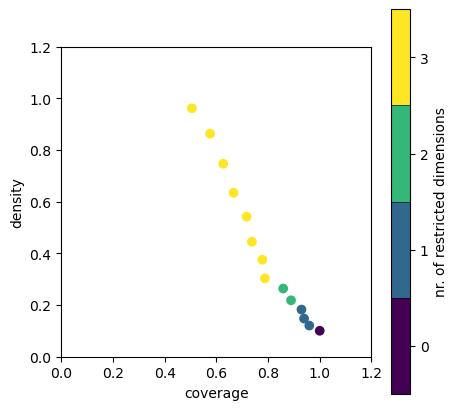

In [12]:
# Setting the upper 25% range for the total number of deaths and  damage costs 

percentile_damage = np.percentile(df_aggregate["Total Expected Annual Damage"], 75)
percentile_deaths = np.percentile(df_aggregate["Total Expected Number of Deaths"], 75)

# Bool the values if they are larger than the threshold
selval = pd.DataFrame()
selval["Cost25p"] = df_aggregate["Total Expected Annual Damage"] > percentile_damage
selval["Death25p"] = df_aggregate["Total Expected Number of Deaths"] > percentile_deaths

# If cost and deaths are in the 75th upper percentiles indicate true
y1 = selval["Cost25p"] & selval["Death25p"] 
y1.to_csv('./worst_scenarios_PRIM.csv')

# Execute prim algorithm
# We select the value for peel_alpha by trial and error such that we get all the dimensions as output 
# as well as a threshold above 0.65
prim_alg = prim.Prim(new_experiments, y1, threshold=0.65, peel_alpha=0.2)
box1 = prim_alg.find_box()

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = (5,5)

# Show trade off plot
box1.show_tradeoff()



#plt.savefig("PRIM_tradeoff_scenarios")
plt.show()

In [13]:
box1.peeling_trajectory

,coverage,density,id,mass,mean,res_dim
0,1.0,0.100508,0,1.0,0.100508,0
1,0.959596,0.120558,1,0.8,0.120558,1
2,0.939394,0.147619,2,0.639594,0.147619,1
3,0.929293,0.18254,3,0.511675,0.18254,1
4,0.888889,0.218362,4,0.409137,0.218362,2
5,0.858586,0.263975,5,0.326904,0.263975,2
6,0.787879,0.303502,6,0.260914,0.303502,3
7,0.777778,0.37561,7,0.208122,0.37561,3
8,0.737374,0.445122,8,0.166497,0.445122,3
9,0.717172,0.541985,9,0.132995,0.541985,3


**Box 11** has been chosen even though ideally we would like to see results with a density of over 80%, we will settle for box 11 with density of 74% and coverage of 62% of the sampled outcomes

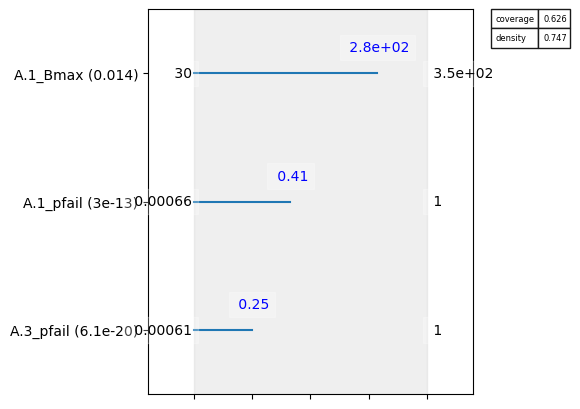

In [14]:
box1.inspect(11, style='graph')
box1.select(11)
#plt.savefig("PRIM_boxinspect_scenarios")
plt.show()

It can be noticed that the three restricted dimensions are A.1_Bmax (Dike breach width A1 Doesburg) , A.1_pfail (Dike failure at A1 Doesburg) and A.3_pfail (Dike failure at A3 Zutphen). All three of the restricted dimensions have a p-value < 0.05 which indicates that all three uncertainties are crucial and contribute to the analysis.
Another observation is that the Probability of failure from 0 - 0.41 and 0 - 0.25 leads to the worst case scenarios, therefore making A1 Doesburg and A.3 Zutphen the most vulnerable dike rings. 

In [15]:
#do able feature scoring at the end. Set x = experiments/selected policies and y = interested outcomes 

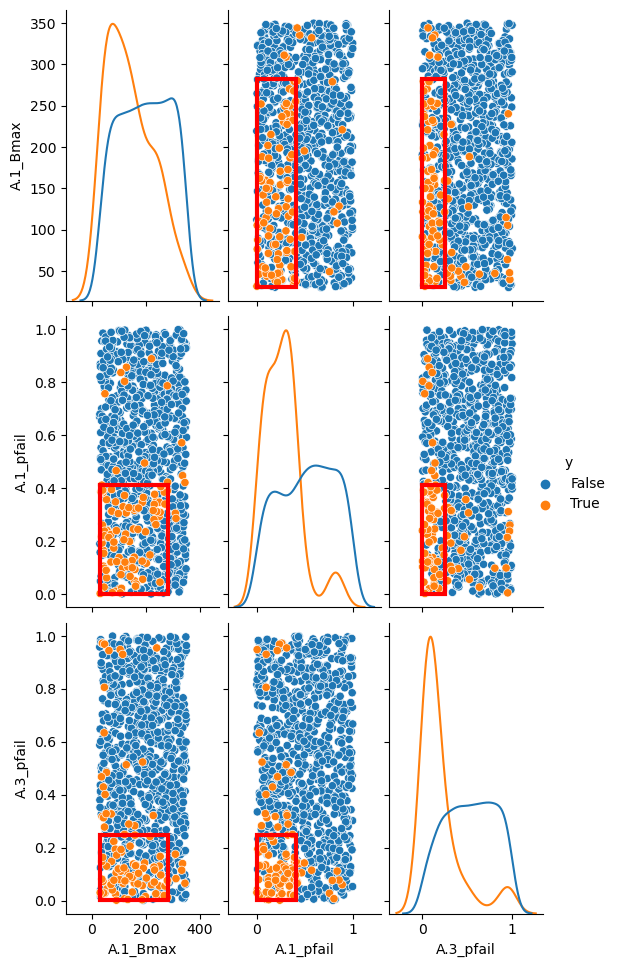

In [16]:
# visualizing the results of PRIM
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(6,10)
#plt.savefig("PRIM_results_dist_scenarios.png")
plt.show()

Scenario Discovery (PRIM): The orange dots represent the desired outcomes, while the blue dots are all the sampled outcomes. The distributed scatter plot shows that the wanted scenarios are concentrated in a very dense region for A.1 pfail and A.3 pfail showcasing the significance of these parameters. 

# Policy Exploration

We explore the different policy levers that are available and their effect on another. 

In [17]:
'''
# import the libaries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import numpy as np
import pickle

# Import the workbench and model
from ema_workbench import (Model, CategoricalParameter, ScalarOutcome, IntegerParameter, RealParameter)
from ema_workbench import (MultiprocessingEvaluator, Policy, Scenario)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging, utilities
from dike_model_function import DikeNetwork 
from ema_workbench import load_results
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import prim

ema_logging.log_to_stderr(ema_logging.INFO)

'''

'\n# import the libaries\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nfrom sklearn import preprocessing\nimport numpy as np\nimport pickle\n\n# Import the workbench and model\nfrom ema_workbench import (Model, CategoricalParameter, ScalarOutcome, IntegerParameter, RealParameter)\nfrom ema_workbench import (MultiprocessingEvaluator, Policy, Scenario)\nfrom ema_workbench.em_framework.evaluators import perform_experiments\nfrom ema_workbench.em_framework.samplers import sample_uncertainties\nfrom ema_workbench.util import ema_logging, utilities\nfrom dike_model_function import DikeNetwork \nfrom ema_workbench import load_results\nfrom problem_formulation import get_model_for_problem_formulation\nfrom ema_workbench.analysis import prim\n\nema_logging.log_to_stderr(ema_logging.INFO)\n\n'

We load the results of the random policy run for 400 scenarios and 100 policies done in the previous notebook. 

In [19]:
 # import results
 from ema_workbench import load_results
 experiments_p, outcomes_df_p = load_results('./results/policies_fully_disaggregated.tar.gz')
 outcomes_df_p = pd.DataFrame.from_dict(outcomes_df_p)
 outcomes_df_p.head()

,A.1_Expected Annual Damage 0,A.1_Dike Investment Costs 0,A.1_Expected Number of Deaths 0,A.2_Expected Annual Damage 0,A.2_Dike Investment Costs 0,A.2_Expected Number of Deaths 0,A.3_Expected Annual Damage 0,A.3_Dike Investment Costs 0,A.3_Expected Number of Deaths 0,A.4_Expected Annual Damage 0,...,A.3_Dike Investment Costs 2,A.3_Expected Number of Deaths 2,A.4_Expected Annual Damage 2,A.4_Dike Investment Costs 2,A.4_Expected Number of Deaths 2,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2
0,0.0,8.526436e+07,0.0,5.302356e+07,0,0.005742,0.0,3.139880e+07,0.0,1.069181e+07,...,2.568188e+07,0.0,0.0,8.673386e+06,0.0,0.000000e+00,3.948301e+07,0.000000,217800000.0,0.000000
1,0.0,8.526436e+07,0.0,1.357645e+06,0,0.000244,0.0,3.139880e+07,0.0,8.357101e+05,...,2.568188e+07,0.0,0.0,8.673386e+06,0.0,8.432576e+05,3.948301e+07,0.000116,217800000.0,73.837395
2,0.0,8.526436e+07,0.0,2.171279e+07,0,0.002411,0.0,3.139880e+07,0.0,0.000000e+00,...,2.568188e+07,0.0,0.0,8.673386e+06,0.0,0.000000e+00,3.948301e+07,0.000000,217800000.0,0.000000
3,0.0,8.526436e+07,0.0,2.157793e+07,0,0.003005,0.0,3.139880e+07,0.0,0.000000e+00,...,2.568188e+07,0.0,0.0,8.673386e+06,0.0,0.000000e+00,3.948301e+07,0.000000,217800000.0,0.000000
4,0.0,8.526436e+07,0.0,6.413019e+07,0,0.008581,0.0,3.139880e+07,0.0,0.000000e+00,...,2.568188e+07,0.0,0.0,8.673386e+06,0.0,2.566302e+07,3.948301e+07,0.002150,217800000.0,1395.133165


In [20]:
outcomes_df_p.columns

Index(['A.1_Expected Annual Damage 0', 'A.1_Dike Investment Costs 0',
       'A.1_Expected Number of Deaths 0', 'A.2_Expected Annual Damage 0',
       'A.2_Dike Investment Costs 0', 'A.2_Expected Number of Deaths 0',
       'A.3_Expected Annual Damage 0', 'A.3_Dike Investment Costs 0',
       'A.3_Expected Number of Deaths 0', 'A.4_Expected Annual Damage 0',
       'A.4_Dike Investment Costs 0', 'A.4_Expected Number of Deaths 0',
       'A.5_Expected Annual Damage 0', 'A.5_Dike Investment Costs 0',
       'A.5_Expected Number of Deaths 0', 'RfR Total Costs 0',
       'Expected Evacuation Costs 0', 'A.1_Expected Annual Damage 1',
       'A.1_Dike Investment Costs 1', 'A.1_Expected Number of Deaths 1',
       'A.2_Expected Annual Damage 1', 'A.2_Dike Investment Costs 1',
       'A.2_Expected Number of Deaths 1', 'A.3_Expected Annual Damage 1',
       'A.3_Dike Investment Costs 1', 'A.3_Expected Number of Deaths 1',
       'A.4_Expected Annual Damage 1', 'A.4_Dike Investment Costs 1',
   

In [21]:
 # function to aggregate over time and locations
 def aggregate_df(df):
     df_aggregate_time = pd.DataFrame()
     df_aggregate_time_location = pd.DataFrame()
     locations = ['A.1', 'A.2', 'A.3', 'A.4', 'A.5']
     step = ['0', '1', '2']
     metrics = ['Expected Annual Damage', 'Dike Investment Costs', 'Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs']
    
     for metric in metrics:
         if metric == "RfR Total Costs" or metric == "Expected Evacuation Costs":

             columns = [metric + ' ' + time for time in step]

             df_aggregate_time_location[metric + ' TA'] = df[columns].sum(axis=1)
         else:
             for location in locations:
                 columns = [location + '_' + metric + ' ' + time for time in step]

                 df_aggregate_time[location + '_' + metric + ' TA'] = df[columns].sum(axis=1)
            
             columns_locations = [location + '_' + metric + ' TA' for location in locations]
             df_aggregate_time_location[metric + ' TLA'] = df_aggregate_time[columns_locations].sum(axis=1)
    
     df_aggregate_time_location['Total Policy Costs'] = df_aggregate_time_location['Dike Investment Costs TLA'] +\
                                                        df_aggregate_time_location['RfR Total Costs TA'] +\
                                                        df_aggregate_time_location['Expected Evacuation Costs TA']
    
     return df_aggregate_time, df_aggregate_time_location

In [22]:
 # here, we aggregate policy outcomes over time and locations
 # we also add the new variable of 'total policy costs'
 df_t_p, df_tl_p = aggregate_df(outcomes_df_p)
 df_tl_p.head()

,Expected Annual Damage TLA,Dike Investment Costs TLA,Expected Number of Deaths TLA,RfR Total Costs TA,Expected Evacuation Costs TA,Total Policy Costs
0,6.640217e+07,5.214857e+08,0.006540,1.032400e+09,4342.720024,1.553890e+09
1,1.431763e+08,5.214857e+08,0.020768,1.032400e+09,14135.706539,1.553900e+09
2,5.264942e+07,5.214857e+08,0.005515,1.032400e+09,3435.481123,1.553889e+09
3,2.574227e+07,5.214857e+08,0.003705,1.032400e+09,2114.795713,1.553888e+09
4,5.248435e+08,5.214857e+08,0.056785,1.032400e+09,41013.023532,1.553927e+09


Now we have the following outcomes:   <br><br>
    * Expected Annual Damage / loc / timestep <br>
    * Dike Investment Costs / loc / timestep <br>
    * Expected Number of Deaths  / loc / timestep <br>
    * RfR Total Costs / timestep <br>
    * Expected Evacuation Costs / timestep <br>
    * **Total Policy Costs** 

## Discovering Effective Policies

In [23]:
experiments_p.columns

Index(['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'EWS_DaysToThreat', 'scenario', 'policy', 'model'],
      dtype='object')

The policy levers are listed above, namely dikeincrease and RfR. These are spread over different dike rings, different time steps.  

In [24]:
# selecting the columns that represent the policy levers
pol_experiments = experiments_p.iloc[:,19:-3]
pol_experiments.columns

Index(['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2',
       '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2',
       '4_RfR 0', '4_RfR 1', '4_RfR 2', 'A.1_DikeIncrease 0',
       'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0',
       'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0',
       'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0',
       'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0',
       'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2', 'EWS_DaysToThreat'],
      dtype='object')

In [25]:
# aggregating the policy levers over the different timesteps

def agg_time(df):
    df_aggregate_time = pd.DataFrame()
    locations = ['A.1', 'A.2', 'A.3', 'A.4', 'A.5']
    locations_number = ['0', '1', '2', '3', '4']
    step = ['0', '1', '2']
    metrics = ['RfR', 'DikeIncrease']
    
    for metric in metrics:
        if metric == "RfR":
            for i, location in enumerate(locations_number):
            
                columns = [location + '_' + metric + ' ' + time for time in step]

                df_aggregate_time[locations[i] + '_' + metric] = df[columns].sum(axis=1)
        else:
            for location in locations:
                columns = [location + '_' + metric + ' ' + time for time in step]

                df_aggregate_time[location + '_' + metric] = df[columns].sum(axis=1)
    return df_aggregate_time

pol_exp_ta = agg_time(pol_experiments)

In [26]:
pol_exp_ta.columns

Index(['A.1_RfR', 'A.2_RfR', 'A.3_RfR', 'A.4_RfR', 'A.5_RfR',
       'A.1_DikeIncrease', 'A.2_DikeIncrease', 'A.3_DikeIncrease',
       'A.4_DikeIncrease', 'A.5_DikeIncrease'],
      dtype='object')

From the basecase vs policies in the previous notebook the variation between the policy outcomes and the base case outcomes can be seen. The threshold for damages, deaths and costs were set around 35-40% each, whereas the policies such as dikeheightening, RfR and evacuation costs were set around 50%. 

In [27]:
# Calculate the value (threshold) where the lower ranges start for each of the KPIs
percentile_damage = np.percentile(df_tl_p["Expected Annual Damage TLA"], 35)
percentile_deaths = np.percentile(df_tl_p["Expected Number of Deaths TLA"], 35)
percentile_costs = np.percentile(df_tl_p["Total Policy Costs"], 40)

percentile_heightening = np.percentile(df_tl_p["Dike Investment Costs TLA"], 50)
percentile_rfr = np.percentile(df_tl_p["RfR Total Costs TA"], 50)
percentile_evac = np.percentile(df_tl_p["Expected Evacuation Costs TA"], 80)

# Bool the values if they are smaller than the threshold
selval1 = pd.DataFrame()
selval1["Damage_bool"] = df_tl_p["Expected Annual Damage TLA"] < percentile_damage
selval1["Death_bool"] = df_tl_p["Expected Number of Deaths TLA"] < percentile_deaths
selval1["Costs_bool"] = df_tl_p["Total Policy Costs"] < percentile_costs

selval1["Heightening_bool"] = df_tl_p["Dike Investment Costs TLA"] < percentile_heightening
selval1["RfR_bool"] = df_tl_p["RfR Total Costs TA"] < percentile_rfr
selval1["Evac_bool"] = df_tl_p["Expected Evacuation Costs TA"] < percentile_evac


# combine all requirements to make final selection of policies of interest
y = selval1["Damage_bool"] & selval1["Death_bool"] & selval1["Costs_bool"] & selval1["Heightening_bool"] & selval1["RfR_bool"] & selval1["Evac_bool"]

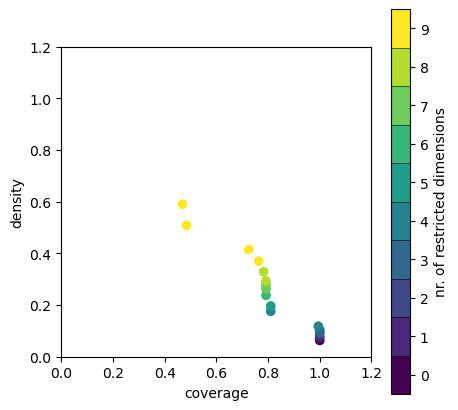

In [28]:
# We select the value for peel_alpha by trial and error such that we get all the dimensions as output 
# as well as a threshold above 0.59
prim_alg = prim.Prim(pol_exp_ta, y, threshold=0.59, peel_alpha=0.05)
box1 = prim_alg.find_box()

# Show trade off plot
box1.show_tradeoff()
#plt.savefig("PRIM_tradeoff_policies")
plt.show()

Ideally, the density should be around 0.8, but in the PRIM process executed here that coverage was not reached. Therefore, we selected the prim box with the best possible density of approximately 60%.

In [29]:
box1.peeling_trajectory

,coverage,density,id,mass,mean,res_dim
0,1.0,0.063,0,1.0,0.063,0
1,1.0,0.075,1,0.84,0.075,1
2,1.0,0.088732,2,0.71,0.088732,2
3,1.0,0.095455,3,0.66,0.095455,3
4,1.0,0.105,4,0.6,0.105,3
5,0.994444,0.118208,5,0.53,0.118208,4
6,0.810317,0.176034,6,0.29,0.176034,4
7,0.810317,0.196346,7,0.26,0.196346,5
8,0.792063,0.237619,8,0.21,0.237619,6
9,0.792063,0.262632,9,0.19,0.262632,7


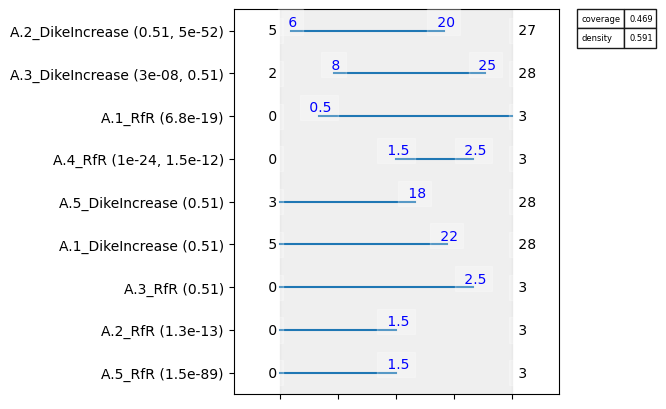

In [30]:
box1.inspect(16, style='graph')
box1.select(16)
#plt.savefig("PRIM_boxinspect_policies")
plt.show()


We notice that there are 9 restricted dimensions, however as the P-values of some of the restrited dimensions is over 0.05 these are considered not as significant for the analysis. THerefore, there are 6 policy levers that significantly result in effective policies. We inspect these closer by plotting them independely. thus we continue with only the following: <br>
* A.3 DikeIncrease <br>
* A.1_RfR <br>
* A.2_RfR <br>
* A.3_RfR <br>
* A.4_RfR <br>
* A.5_RfR <br>

The box inspection also gives insight into the length to which the policies should be applied, for example the dike heightening does not need to be done for 30 dcm in most cases. 

In [31]:
pol_exp_ta['Desired'] = y

In [32]:
pol_exp_ta.head(2)

,A.1_RfR,A.2_RfR,A.3_RfR,A.4_RfR,A.5_RfR,A.1_DikeIncrease,A.2_DikeIncrease,A.3_DikeIncrease,A.4_DikeIncrease,A.5_DikeIncrease,Desired
0,1.0,2.0,0.0,0.0,2.0,18.0,8.0,8.0,7.0,9.0,False
1,1.0,2.0,0.0,0.0,2.0,18.0,8.0,8.0,7.0,9.0,False


In [50]:
pol_exp_ta['policy'] = "policy"
pol_exp_ta['policy']= pol_exp_ta.index
pol_exp_ta.head(2)

,A.1_RfR,A.2_RfR,A.3_RfR,A.4_RfR,A.5_RfR,A.1_DikeIncrease,A.2_DikeIncrease,A.3_DikeIncrease,A.4_DikeIncrease,A.5_DikeIncrease,Desired,policy,Policy no
0,1.0,2.0,0.0,0.0,2.0,18.0,8.0,8.0,7.0,9.0,False,0,Policy0 0\n1 1\n2 ...
1,1.0,2.0,0.0,0.0,2.0,18.0,8.0,8.0,7.0,9.0,False,1,Policy0 0\n1 1\n2 ...


In [53]:
pol_exp_ta.head()

,A.1_RfR,A.2_RfR,A.3_RfR,A.4_RfR,A.5_RfR,A.1_DikeIncrease,A.2_DikeIncrease,A.3_DikeIncrease,A.4_DikeIncrease,A.5_DikeIncrease,Desired,policy
0,1.0,2.0,0.0,0.0,2.0,18.0,8.0,8.0,7.0,9.0,False,0
1,1.0,2.0,0.0,0.0,2.0,18.0,8.0,8.0,7.0,9.0,False,1
2,1.0,2.0,0.0,0.0,2.0,18.0,8.0,8.0,7.0,9.0,False,2
3,1.0,2.0,0.0,0.0,2.0,18.0,8.0,8.0,7.0,9.0,False,3
4,1.0,2.0,0.0,0.0,2.0,18.0,8.0,8.0,7.0,9.0,False,4


In [52]:
#pol_exp_ta.to_csv("./results/PRIM_policy_exploration")

In [47]:
pol_exp_ta.head(2)

,A.1_RfR,A.2_RfR,A.3_RfR,A.4_RfR,A.5_RfR,A.1_DikeIncrease,A.2_DikeIncrease,A.3_DikeIncrease,A.4_DikeIncrease,A.5_DikeIncrease,Desired,policy,Policy no
0,1.0,2.0,0.0,0.0,2.0,18.0,8.0,8.0,7.0,9.0,False,0,Policy0 0\n1 1\n2 ...
1,1.0,2.0,0.0,0.0,2.0,18.0,8.0,8.0,7.0,9.0,False,1,Policy0 0\n1 1\n2 ...


<Figure size 2000x1000 with 0 Axes>

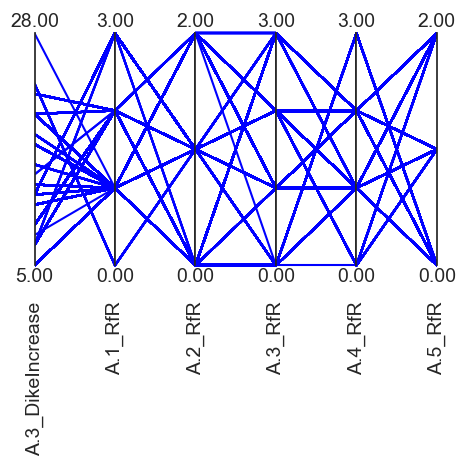

In [58]:

# conditional on y
from matplotlib.pyplot import figure

figure(figsize=(20, 10))
df_plot = pol_exp_ta[pol_exp_ta['Desired'] == True]
df_plot = df_plot[['A.3_DikeIncrease', 'A.1_RfR', 'A.2_RfR', 'A.3_RfR', 'A.4_RfR', 'A.5_RfR']]

limits = parcoords.get_limits(df_plot)
axes = parcoords.ParallelAxes(limits)
axes.plot(df_plot, color='blue') #include only the variables that are significant according to prim
# axes.invert_axis('max_P')
#plt.savefig("./results/randompoliciesPRIM1.png")
plt.show()

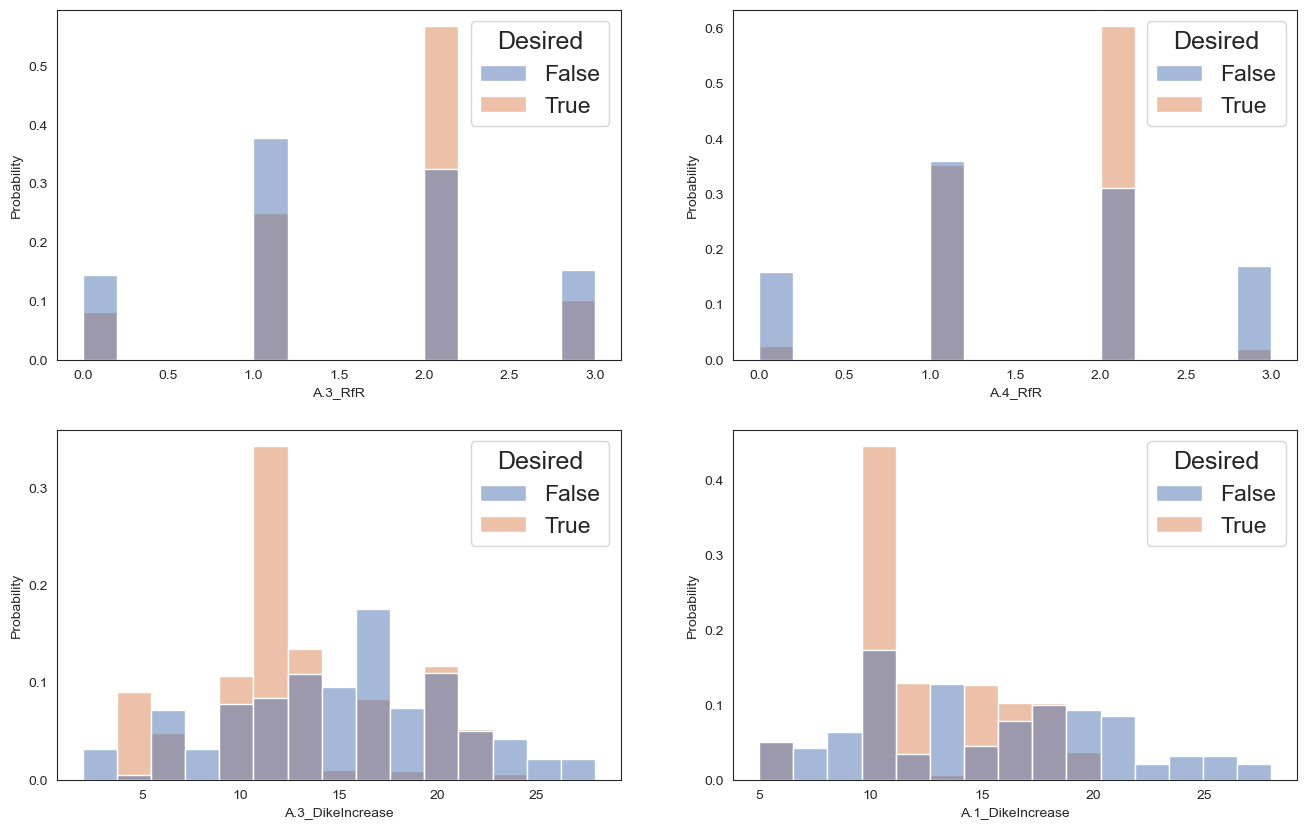

In [56]:
f, axes = plt.subplots(2, 2, figsize=(16,10))
sns.set(style="whitegrid", font_scale=1.5)
plt.rcParams["axes.labelsize"] = 18

sns.histplot(pol_exp_ta, x='A.3_RfR', hue='Desired',  kde=False, bins=15, stat='probability', common_bins=True, common_norm=False, ax=axes[0,0])

sns.histplot(pol_exp_ta, x='A.4_RfR', hue='Desired',  kde=False, bins=15, stat='probability', common_bins=True, common_norm=False, ax=axes[0,1])

sns.histplot(pol_exp_ta, x='A.3_DikeIncrease', hue='Desired',  kde=False, bins=15, stat='probability', common_bins=True, common_norm=False, ax=axes[1,0])

sns.histplot(pol_exp_ta, x='A.1_DikeIncrease', hue='Desired',  kde=False, bins=15, stat='probability', common_bins=True, common_norm=False, ax=axes[1,1])

#plt.savefig("./randompolicies_PRIM2.png", bbox_inches = 'tight', pad_inches = 0)

The above plot shows that in order to get effective policies while having low total costs, it is not necassary to implement policy levers to their maximum. For instance, maximum dike heightening is not desired.

Below, we also analyse how the policy levers in each timestep contribute to the policies. This follows the same approach as described previously.

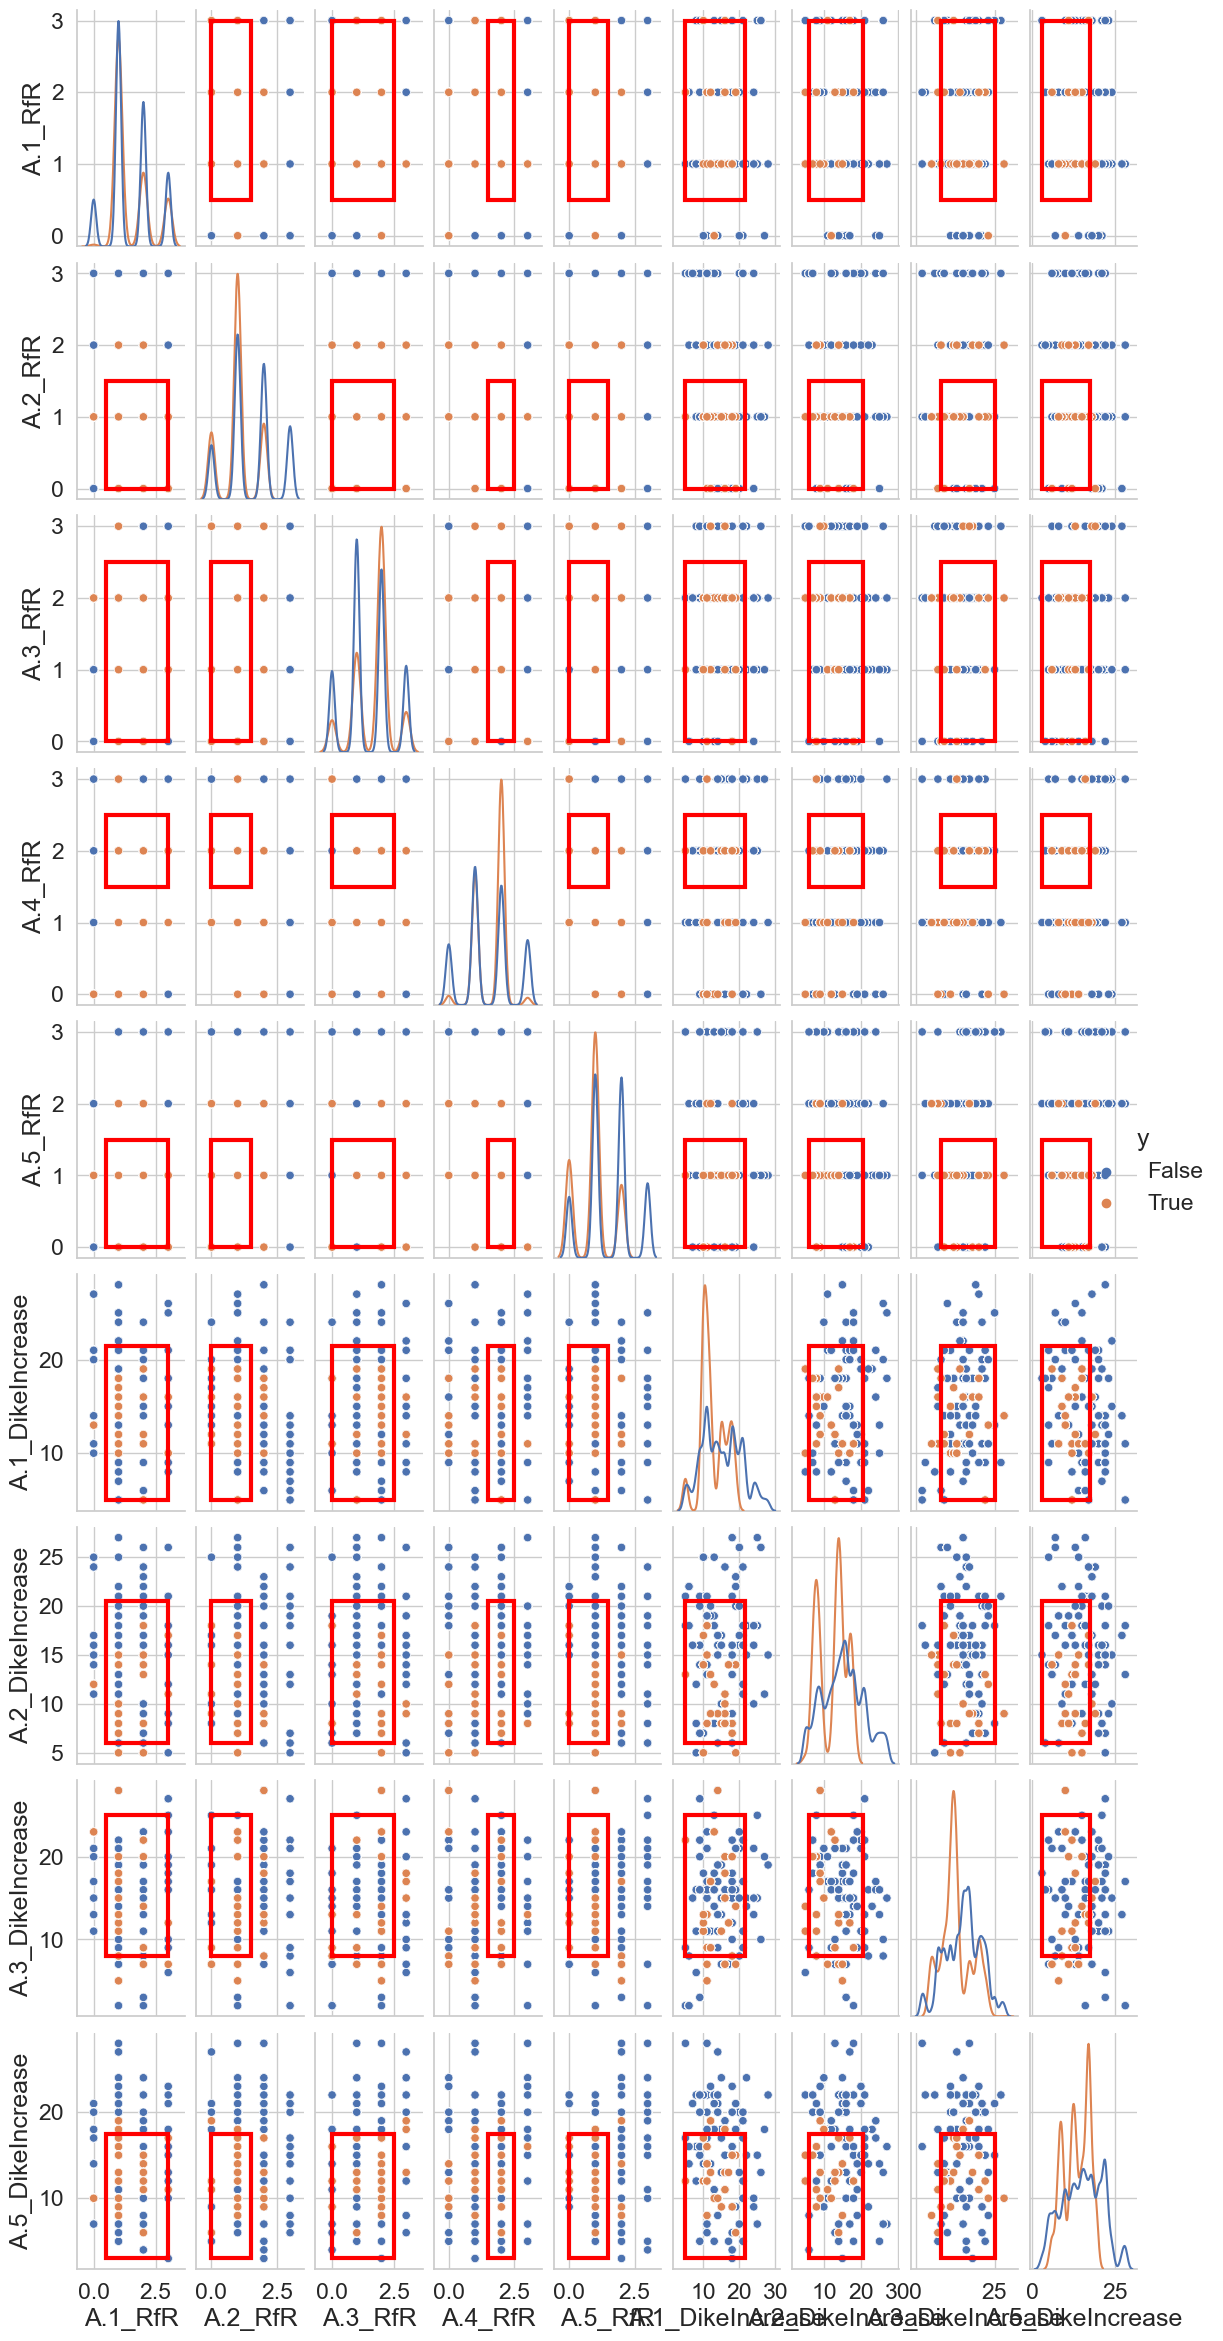

In [57]:
# visualizing the results of PRIM
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,24)
# plt.savefig("../images/PRIM_results_distributionmatrix.png")
plt.show()